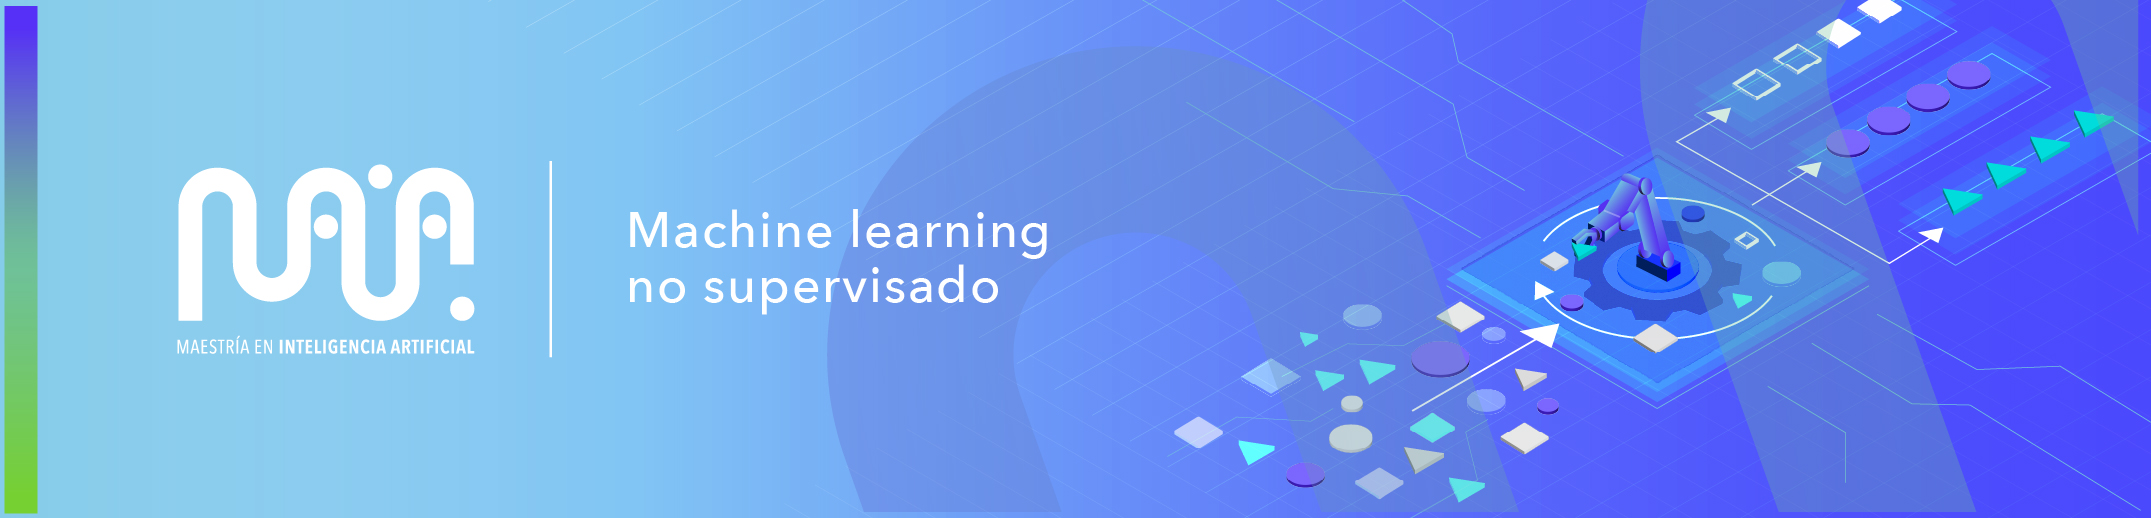

# Detección de anomalías con LOF

En este tutorial aprenderás cómo ejecutar el algoritmo de detección de anomalías LOF (Local Outlier Factor). Primero aplicarás el algoritmo para medir la desviación de densidad local de cada punto del conjunto de datos con respecto a sus vecinos, obteniendo predicciones de anomalías. Adicionalmente, utilizarás las etiquetas del conjunto de datos para comparar las anomalías detectadas por el algoritmo con respecto a la realidad, identificando algunas consideraciones para este tipo de problema. En ese sentido, los pasos que realizaremos son:

1. [Importar las librerías necesarias.](#1.-Importación-de-librerías-requeridas)
2. [Cargar y procesar un conjunto de datos.](#2.-Carga-y-preprocesamiento-de-datos)
3. [Aplicar el algoritmo de Local Outlier Factor.](#3.-Detección-de-anomalías-con-LOF)
4. [Evaluar el resultado.](#4.-Evaluación-del-modelo)

---

<font size="3">**Contexto**  
<font size="2"> 
El conjunto de datos que utilizaremos se relaciona con la caracterización de clientes de un banco que tienen préstamos activos, utilizando atributos como el monto financiado, la tasa de interés, el balance del préstamo, entre otros. Específicamente, usaremos una versión modificada del conjunto de datos [Bank Loan Defaulter Prediction](https://www.kaggle.com/datasets/ankitkalauni/bank-loan-defaulter-prediction-hackathon), con el objetivo de identificar si un cliente determinado incumplirá su préstamo o no.

## 1. Importación de librerías requeridas

Importaremos las librerías `pandas`, `numpy`, y `scikit-learn`, así como la librería de visualización `matplotlib`. En particular, utilizaremos las siguientes clases:

* [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html): clase para realizar la estandarización de datos.
* [`LocalOutlierFactor()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html): clase para ejecutar el algoritmo LOF para detección de anomalías.
* [`PCA()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html): clase para realizar una reducción de la dimensionalidad con el algoritmo PCA.
* [`TSNE()`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html): clase para realizar una reducción de la dimensionalidad con el algoritmo t-SNE.
* [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html): función para calcular la exactitud usando las etiquetas reales y las predicciones realizadas por un modelo.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

## 2. Carga y preprocesamiento de datos

Realizaremos la carga de datos usando la función de Pandas `read_csv()`, especificando la ruta y el separador del archivo:

In [3]:
data = pd.read_csv('./data/bank_loan.csv', sep=',')
data.head()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Home Ownership,Debit to Income,Delinquency - two years,Inquires - six months,...,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,11.135007,176346.62670,16.284758,1,0,...,0.102055,2.498291,0.793724,0,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,12.237563,39833.92100,15.412409,0,0,...,0.036181,2.377215,0.974821,0,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,12.545884,91506.69105,28.137619,0,0,...,18.778660,4.316277,1.020075,0,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,16.731201,108286.57590,18.043730,1,0,...,0.044131,0.107020,0.749971,0,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,15.008300,44234.82545,17.209886,1,3,...,19.306646,1294.818751,0.368953,0,18,0,430,126029,22579,0


Vamos a revisar la variable objetivo `Loan Status` para ver cómo se distribuyen nuestros datos entre clientes en riesgo y clientes normales. Primero utilizaremos la función `value_counts()` para tener una idea de la cantidad de datos por clase:

In [4]:
status_counts = data['Loan Status'].value_counts()
status_counts

Loan Status
0    61222
1     6241
Name: count, dtype: int64

Como puedes ver, tenemos solamente 6241 datos pertenecientes a la clase positiva, lo que se traduce al 9.25% del total de datos. Por otro lado, la clase negativa tiene 61222 datos. Podemos visualizar la diferencia utilizando la función `plot()` de Pandas, indicando que queremos construir un gráfico de barras:

<Axes: xlabel='Loan Status'>

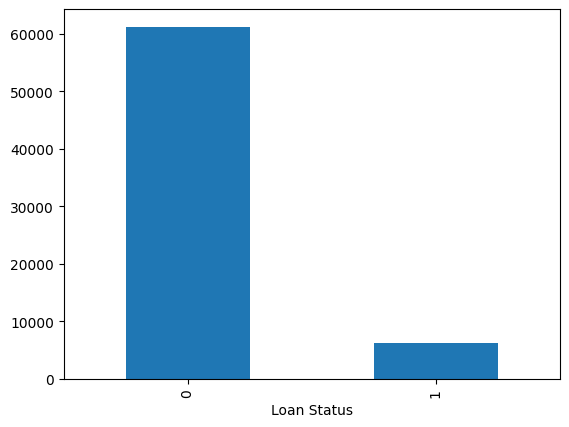

In [5]:
status_counts.plot(kind='bar')

### Eliminación de variables poco relevantes

Eliminaremos la variable `ID`, que no tiene información relevante para la detección de clientes que van a incumplir el préstamo:

In [6]:
data = data.drop(['ID'], axis=1)

### Tratamiento de nulos y duplicados
Primero veremos la cantidad de datos nulos en nuestro conjunto:

In [7]:
data.isna().sum()

Loan Amount                     0
Funded Amount                   0
Funded Amount Investor          0
Term                            0
Interest Rate                   0
Home Ownership                  0
Debit to Income                 0
Delinquency - two years         0
Inquires - six months           0
Open Account                    0
Public Record                   0
Revolving Balance               0
Revolving Utilities             0
Total Accounts                  0
Total Received Interest         0
Total Received Late Fee         0
Recoveries                      0
Collection Recovery Fee         0
Collection 12 months Medical    0
Last week Pay                   0
Accounts Delinquent             0
Total Collection Amount         0
Total Current Balance           0
Total Revolving Credit Limit    0
Loan Status                     0
dtype: int64

También veremos la cantidad de datos duplicados:

In [8]:
data.duplicated().sum()

0

Como no tenemos datos nulos ni duplicados, podemos avanzar con la separación de las etiquetas del conjunto de datos.

### Separación de etiquetas del conjunto

Vamos a separar la variable `Loan Status`, que contiene información sobre los clientes que incumplen con el préstamo. Nuestro objetivo es obtener una predicción similar utilizando únicamente variables descriptoras de cada cliente:

In [9]:
x = data.drop('Loan Status', axis=1)
y = data['Loan Status']

### Estandarización

Finalmente, vamos a definir un objeto de la clase `StandardScaler()` para realizar la estandarización:

In [10]:
standard_scaler = StandardScaler()

Debido a que LOF es muy sensible a la escala de los datos, al utilizar métricas de distancia (como la distancia euclidiana) para calcular la densidad local de cada ejemplo, es preferible estandarizar el conjunto para que no se presenten sesgos hacia algunas variables.

In [11]:
scaler = StandardScaler()
x_std = scaler.fit_transform(x)

## 3. Detección de anomalías con LOF

Primero definiremos un objeto de la clase `LocalOutlierFactor()` con el parámetro `contamination`, que se define como la proporción de outliers en el conjunto de datos (un valor entre 0 y 0.5). En el caso de detección de anomalías, vamos a asumir que nuestros ejemplos positivos (con `Loan Status` igual a 1) presentan un comportamiento que se desvía de la distribución de todo el conjunto, por lo que iniciaremos con un valor de `contamination=0.1`, tal como se observó al cargar el conjunto de datos. Sin embargo, este valor puede ser modificado como un hiperparámetro para conseguir un mejor rendimiento del algoritmo.

Con este algoritmo, las anomalías se definirán como aquellos ejemplos que tengan una densidad menor a la de sus vecinos. Lo aplicaremos sobre el conjunto estandarizado `x_std`, obteniendo directamente las predicciones sobre nuestro conjunto:

In [12]:
lof = LocalOutlierFactor(contamination=0.1)
y_pred = lof.fit_predict(x_std)
y_pred

array([-1,  1,  1, ..., -1,  1,  1])

Por defecto las predicciones se retornan como `-1` para anomalías y `1` para datos internos. Podemos realizar una comparación booleana para convertir las predicciones a un `1` si el dato es una anomalía o un `0` de lo contrario:

In [13]:
y_pred = (y_pred == -1).astype(int)
y_pred

array([1, 0, 0, ..., 1, 0, 0])

Por otro lado, podemos obtener el opuesto del LOF. Los datos internos o normales usualmente tienden a una puntuación LOF cercana a 1 (`negative_outlier_factor_` cercana a -1), mientras que las anomalías tienden a una puntuación LOF mayor (`negative_outlier_factor_` menor a -1):

In [14]:
x_scores = lof.negative_outlier_factor_
x_scores

array([-1.22289427, -0.99793347, -1.02110819, ..., -1.238838  ,
       -1.12720742, -1.13846686])

## 4. Evaluación del modelo

Realizaremos una reducción de la dimensionalidad con PCA y TSNE para visualizar el resultado:

In [15]:
x_reduced = PCA(n_components=0.95).fit_transform(x_std)
x_tsne = pd.DataFrame(TSNE(random_state=0).fit_transform(x_reduced))

Utilizaremos las variables `y` y `y_pred` para graficar las anomalías reales y las identificadas por LOF. Como puedes ver, el algoritmo tiende a etiquetar como anomalías los ejemplos ubicados en regiones de menor densidad. Sin embargo, es complicado sacar conclusiones debido a la reducción de la dimensionalidad:

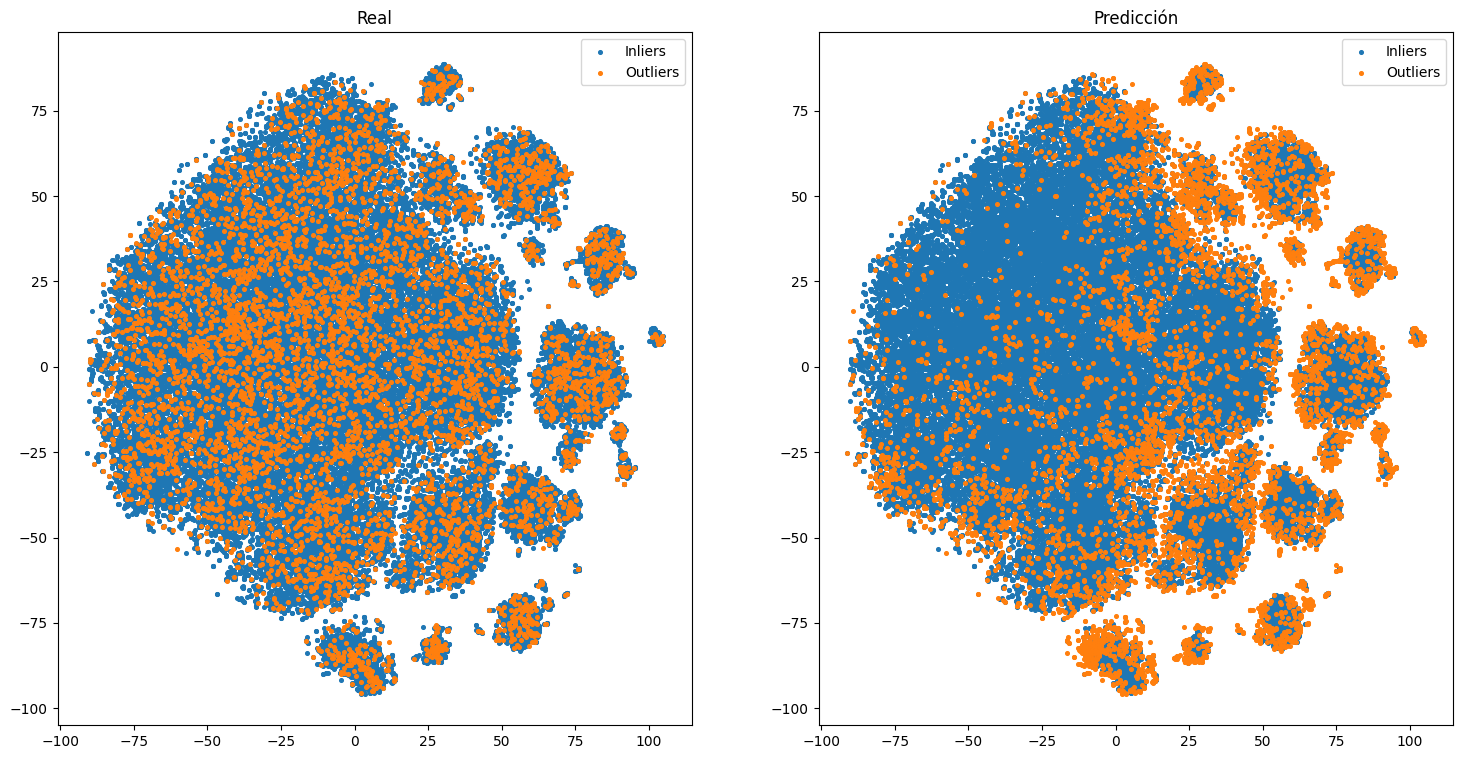

In [16]:
labels = ['Inliers', 'Outliers']
fig, axs = plt.subplots(1, 2, figsize=(18, 9))
for i in range(2):
    selections = x_tsne.iloc[y[y==i].index]
    selections_pred = x_tsne.iloc[y_pred==i]
    axs[0].scatter(selections[0], selections[1], label=labels[i], s=7)
    axs[1].scatter(selections_pred[0], selections_pred[1], label=labels[i], s=7)
axs[0].set_title('Real')
axs[1].set_title('Predicción')
axs[0].legend()
axs[1].legend()

plt.show()

Además, podemos revisar la cantidad de errores que cometió el modelo. Para esto, realizaremos una comparación uno-a-uno y obtendremos el número de errores cometidos:

In [17]:
n_errors = (y_pred != y).sum()
print(f'Errores: {n_errors}')

Errores: 11640


Teniendo en cuenta que  nuestro conjunto tiene 67463 datos, se podría decir que la proporción de errores es pequeña. Incluso, al obtener la exactitud utilizando las predicciones y las etiquetas originales, tenemos un "buen desempeño":

In [18]:
accuracy = accuracy_score(y, y_pred)
print(f'Exactitud: {accuracy:.2f}')

Exactitud: 0.83


Sin embargo, teniendo en cuenta que la naturaleza de este problema es desbalanceada, métricas como la exactitud pueden no ser correctas para determinar el desempeño del modelo. En cambio, podemos concentrarnos en la cantidad de anomalías que había originalmente:

In [19]:
n_outliers = data['Loan Status'].sum()
n_outliers

6241

Si revisamos los errores cometidos por el modelo para este subconjunto, veremos una tendencia diferente:

In [20]:
# Realizamos dos comparaciones:
# 1. La etiqueta real es 1 (es una anomalía).
# 2. La predicción es diferente a la etiqueta real.
outlier_errors = ((y==1) & (y_pred!=y)).astype(int)
n_outlier_errors = outlier_errors.sum()
n_outlier_errors

5567

Como puedes observar, nuestro modelo no pudo identificar el 89% de las anomalías del conjunto. Ten en cuenta que no realizamos una búsqueda de hiperparámetros, utilizando 20 vecinos y la distancia euclidiana como métrica de distancia.

In [21]:
print(f'Ratio (errores/total): {n_outlier_errors/n_outliers:.2f}')

Ratio (errores/total): 0.89


## Cierre

En este tutorial hemos utilizado la clase `LocalOutlierFactor()` para aplicar el algoritmo LOF de detección de anomalías a un conjunto de datos, analizando el resultado sobre la totalidad de datos y únicamente sobre las anomalías. Al ser un problema de naturaleza desbalanceada, es importante seleccionar un criterio específico para determinar el desempeño real del modelo resultante.

<font size="3">**Hands-on**  

* Intenta modificar el valor del parámetro `contamination`. ¿Hay variaciones en el desempeño del modelo con valores diferentes de contaminación?
* El valor de vecinos propuesto por los autores del algoritmo es 20. Intenta cambiar el parámetro `n_neighbors` a otros valores. ¿Afecta este valor al desempeño final del modelo? 
* Igualmente, intenta modificar otros parámetros como `algorithm` o `metric`. ¿Qué combinación de hiperparámetros da el mejor desempeño para este conjunto de datos?

---
*Creado por: Nicolás Díaz*  
*Revisado por: Haydemar Nuñez*  
*Versión de: Febrero 12, 2024*  
*Universidad de los Andes*   